<a href="https://colab.research.google.com/github/dev-69/MajorProject/blob/main/Undersampling%2BOversamplingWithFastTextOnLY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import gensim
from gensim.models import KeyedVectors

In [23]:
df = pd.read_pickle("/content/drive/MyDrive/Major Project Learnings/Prepared_Data.pkl")
df.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE,DAYS_NEXT_ADMIT,index,CATEGORY,TEXT,OUTPUT_LABEL
1,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaT,EMERGENCY,NaT,NaN,NaN,48470.0,Discharge summary,Admission Date: [**2101-10-20**] Discharg...,0
2,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaT,EMERGENCY,NaT,NaN,NaN,4782.0,Discharge summary,Admission Date: [**2191-3-16**] Discharge...,0
4,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaT,ELECTIVE,NaT,NaN,NaN,24476.0,Discharge summary,Admission Date: [**2175-5-30**] Dischar...,0
7,9,150750,2149-11-09 13:06:00,2149-11-14 10:15:00,2149-11-14 10:15:00,EMERGENCY,NaT,NaN,NaN,57341.0,Discharge summary,"Name: [**Known lastname 10050**], [**Known fi...",0
9,11,194540,2178-04-16 06:18:00,2178-05-11 19:00:00,NaT,EMERGENCY,NaT,NaN,NaN,34829.0,Discharge summary,Admission Date: [**2178-4-16**] ...,0


In [24]:
df.TEXT = df.TEXT.fillna(' ')
df.TEXT = df.TEXT.str.replace('\n',' ')
df.TEXT = df.TEXT.str.replace('\r',' ')
df.TEXT = df.TEXT.str.lower()
df.TEXT = df.TEXT.str.replace(r'[^a-zA-Z\s]', '', regex=True)
df.TEXT = df.TEXT.str.replace(r'\s+', ' ', regex=True)
df.TEXT = df.TEXT.str.strip()

In [25]:
df_filtered = df[['SUBJECT_ID', 'HADM_ID', 'TEXT', 'OUTPUT_LABEL']]
X = df_filtered['TEXT']
y = df_filtered['OUTPUT_LABEL']

df_filtered['OUTPUT_LABEL'].value_counts()


,count
OUTPUT_LABEL,
0,48109
1,3004


In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_filtered['TEXT'], df_filtered['OUTPUT_LABEL'], test_size=0.2, random_state=42)

In [27]:
import nltk

nltk.download('punkt_tab')
nltk.download('punkt')


from nltk import word_tokenize
word_tokenize('This should be tokenized. 02/02/2018 sentence has stars**')
import string
print(string.punctuation)
def tokenizer_better(text):
    punc_list = string.punctuation+'0123456789'
    t = str.maketrans(dict.fromkeys(punc_list, " "))
    text = text.lower().translate(t)
    tokens = word_tokenize(text)
    return tokens
my_stop_words = ['the','and','to','of','was','with','a','on','in','for','name',
                 'is','patient','s','he','at','as','or','one','she','his','her','am',
                 'were','you','pt','pm','by','be','had','your','this','date',
                'from','there','an','that','p','are','have','has','h','but','o',
                'namepattern','which','every','also']

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vect = TfidfVectorizer(max_features=1000, tokenizer=tokenizer_better, stop_words=my_stop_words)
X_train_vect = vect.fit_transform(X_train)
X_test_vect = vect.transform(X_test)

print("1. Using TF-IDF Vectorizer")

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


1. Using TF-IDF Vectorizer


In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

def create_sampling_visualization(X_orig, y_orig, title, X_resampled, y_resampled):
    """
    Visualizes the class distribution before and after resampling.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    sns.barplot(
        x=list(Counter(y_orig).keys()),
        y=list(Counter(y_orig).values()),
        ax=axes[0],
        palette='pastel'
    )
    axes[0].set_title('Original Distribution')
    axes[0].set_xlabel('Class')
    axes[0].set_ylabel('Count')

    sns.barplot(
        x=list(Counter(y_resampled).keys()),
        y=list(Counter(y_resampled).values()),
        ax=axes[1],
        palette='Set2'
    )
    axes[1].set_title(f'Resampled: {title}')
    axes[1].set_xlabel('Class')
    axes[1].set_ylabel('Count')

    plt.tight_layout()
    plt.show()


In [29]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek

def visualize_combined_sampling_techniques(X_train, y_train):
    """
    Applies and visualizes all required sampling techniques:
    1. RandomUnderSampler + RandomOverSampler
    2. RandomUnderSampler + SMOTE
    3. RandomUnderSampler + ADASYN
    4. SMOTEENN
    5. SMOTETomek
    """
    sampled_results = {}

    print("\n🔁 RandomUnderSampler + RandomOverSampler")
    rus = RandomUnderSampler()
    X_under, y_under = rus.fit_resample(X_train, y_train)
    ros = RandomOverSampler()
    X_ros, y_ros = ros.fit_resample(X_under, y_under)
    create_sampling_visualization(X_train, y_train, 'Under + RandomOverSampler', X_ros, y_ros)
    sampled_results['Under + ROS'] = (X_ros, y_ros)

    print("\n🔁 RandomUnderSampler + SMOTE")
    rus = RandomUnderSampler()
    X_under, y_under = rus.fit_resample(X_train, y_train)
    smote = SMOTE()
    X_smote, y_smote = smote.fit_resample(X_under, y_under)
    create_sampling_visualization(X_train, y_train, 'Under + SMOTE', X_smote, y_smote)
    sampled_results['Under + SMOTE'] = (X_smote, y_smote)

    print("\n🔁 RandomUnderSampler + ADASYN")
    rus = RandomUnderSampler()
    X_under, y_under = rus.fit_resample(X_train, y_train)
    adasyn = ADASYN()
    X_adasyn, y_adasyn = adasyn.fit_resample(X_under, y_under)
    create_sampling_visualization(X_train, y_train, 'Under + ADASYN', X_adasyn, y_adasyn)
    sampled_results['Under + ADASYN'] = (X_adasyn, y_adasyn)

    # print("\n🔬 SMOTEENN (Hybrid)")
    # smoteenn = SMOTEENN()
    # X_smoteenn, y_smoteenn = smoteenn.fit_resample(X_train, y_train)
    # create_sampling_visualization(X_train, y_train, 'SMOTEENN', X_smoteenn, y_smoteenn)
    # sampled_results['SMOTEENN'] = (X_smoteenn, y_smoteenn)

    # print("\n🔬 SMOTETomek (Hybrid)")
    # smotetomek = SMOTETomek()
    # X_smotetomek, y_smotetomek = smotetomek.fit_resample(X_train, y_train)
    # create_sampling_visualization(X_train, y_train, 'SMOTETomek', X_smotetomek, y_smotetomek)
    # sampled_results['SMOTETomek'] = (X_smotetomek, y_smotetomek)

    return sampled_results



🔁 RandomUnderSampler + RandomOverSampler


<ipython-input-8-c274e155a28c>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-8-c274e155a28c>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


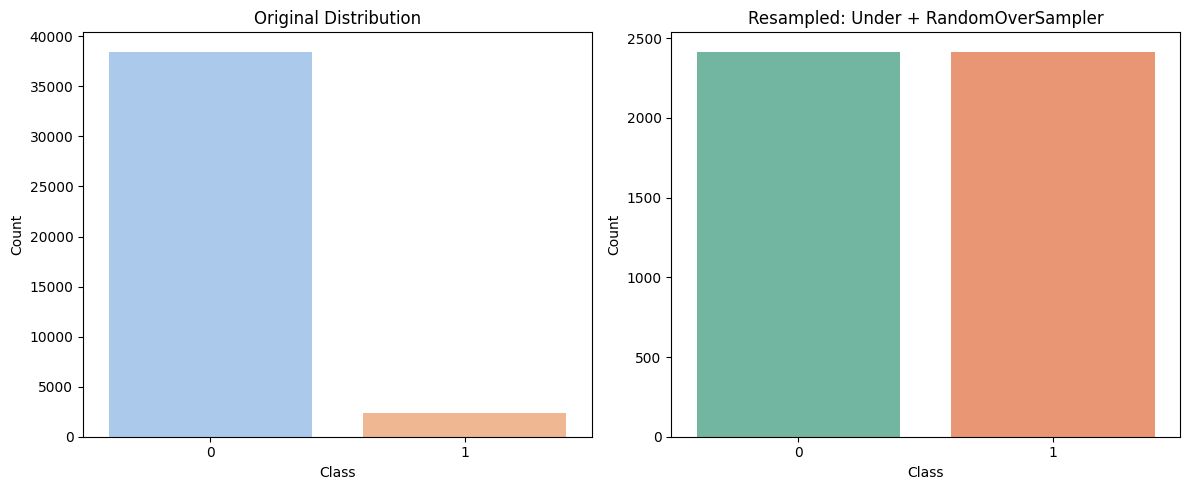


🔁 RandomUnderSampler + SMOTE


<ipython-input-8-c274e155a28c>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-8-c274e155a28c>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


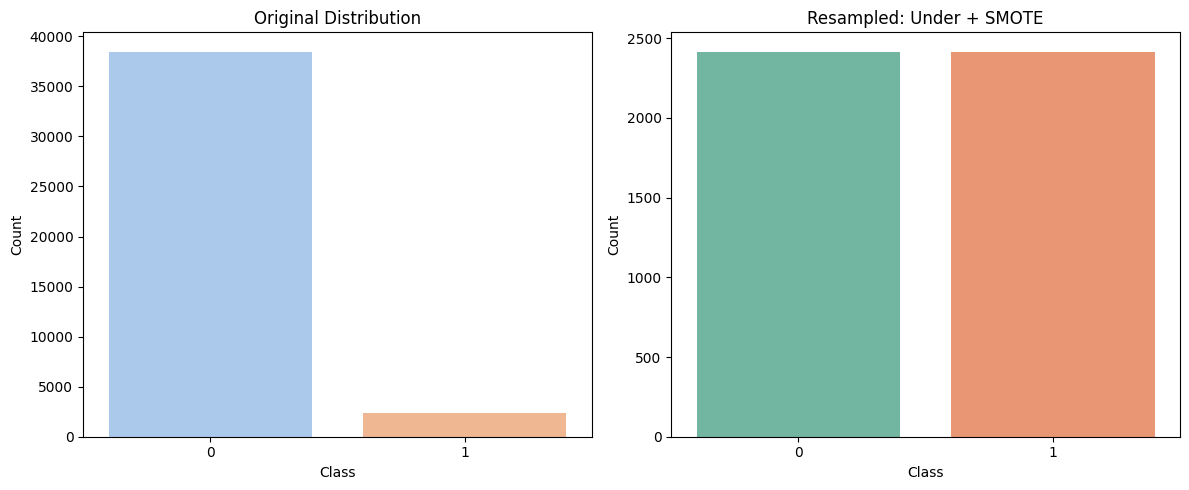


🔁 RandomUnderSampler + ADASYN


<ipython-input-8-c274e155a28c>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-8-c274e155a28c>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


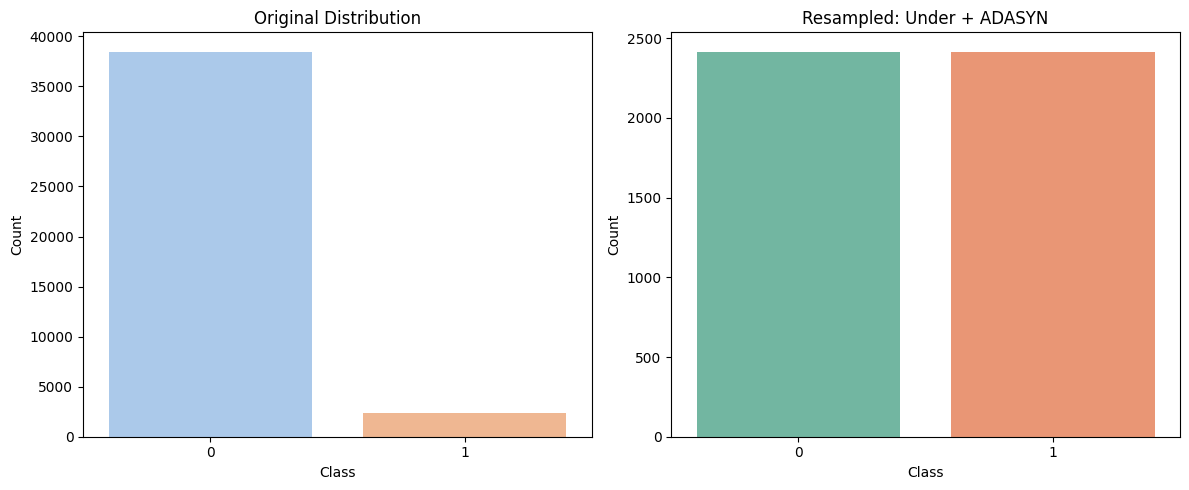

In [ ]:
sampled_data_dict = visualize_combined_sampling_techniques(X_train_vect, y_train)

In [ ]:
X_under_ros, y_under_ros = sampled_data_dict['Under + ROS']
X_under_smote, y_under_smote = sampled_data_dict['Under + SMOTE']
X_under_adasyn, y_under_adasyn = sampled_data_dict['Under + ADASYN']


In [30]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import roc_auc_score, classification_report
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [31]:
def classification(X_train, y_train, X_test, y_test):

    classifiers = [
        KNeighborsClassifier(3),
        DecisionTreeClassifier(max_depth=19, min_samples_split=10),
        RandomForestClassifier(n_estimators=450),
        AdaBoostClassifier(n_estimators=100),
        GradientBoostingClassifier(n_estimators=300),
        LogisticRegression(C=1, penalty='l2')]

    for clf in classifiers:
        clf.fit(X_train, y_train)
        name = clf.__class__.__name__

        print("="*30)
        print(name)

        print('****Results****')
        train_predictions = clf.predict(X_test)

        # AUC Score
        acc = roc_auc_score(y_test, train_predictions)
        print("AUC: {:.4%}".format(acc))

        # Classification Report
        print("Classification report: \n", classification_report_imbalanced(y_test, train_predictions))

        # Confusion Matrix
        cm = confusion_matrix(y_test, train_predictions)

        # Plot confusion matrix using seaborn heatmap
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
        plt.title(f'Confusion Matrix for {name}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

    print("="*30)


In [32]:
def combine_sampling_results(X_under_ros, y_under_ros, X_under_smote, y_under_smote, X_under_adasyn, y_under_adasyn, X_test_vect, y_test):
    """
    Evaluate oversampling results using RandomOverSampler, SMOTE, and ADASYN.
    """

    print("RUS + ROS \n")
    classification(X_under_ros, y_under_ros, X_test_vect, y_test)

    print("RUS + SMOTE \n")
    classification(X_under_smote, y_under_smote, X_test_vect, y_test)

    print("RUS + ADASYN \n")
    classification(X_under_adasyn, y_under_adasyn, X_test_vect, y_test)

In [33]:
combine_sampling_results(X_under_ros, y_under_ros, X_under_smote, y_under_smote, X_under_adasyn, y_under_adasyn, X_test_vect, y_test)

NameError: name 'X_under_ros' is not defined

In [34]:
!pip install fasttext

In [37]:
import gensim
import numpy as np

# Load pre-trained fastText word vectors (text format)
model = gensim.models.KeyedVectors.load_word2vec_format("/content/drive/MyDrive/Major Project Learnings/vectorizers/wiki-news-300d-1M-subword.vec", binary=False)

# Function to average word embeddings for a document
def get_average_word_vector(text, model):
    # Tokenize and get word embeddings for each token
    words = text.split()
    word_vectors = []

    for word in words:
        if word in model:
            word_vec = model[word]
            word_vectors.append(word_vec)

    # If no words are found, return a zero vector (important for edge cases like empty documents)
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)

    # Calculate the average of word vectors
    return np.mean(word_vectors, axis=0)

# Apply this to X_train and X_test
X_train_vect = np.array([get_average_word_vector(text, model) for text in X_train])
X_test_vect = np.array([get_average_word_vector(text, model) for text in X_test])

print("2. Using FastText (with Gensim) Vectorizer")


2. Using FastText (with Gensim) Vectorizer



🔁 RandomUnderSampler + RandomOverSampler


<ipython-input-28-c274e155a28c>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-28-c274e155a28c>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


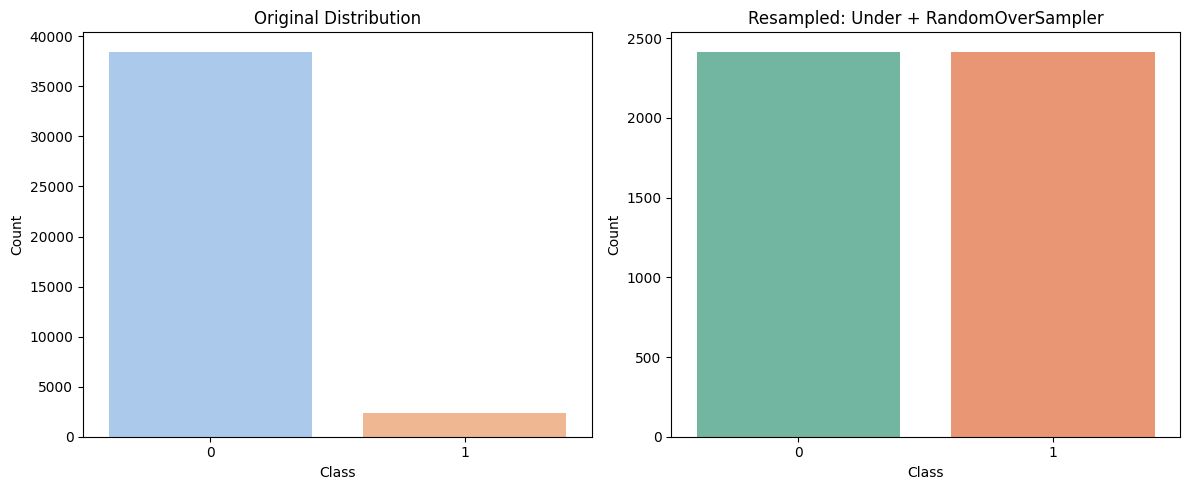


🔁 RandomUnderSampler + SMOTE


<ipython-input-28-c274e155a28c>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-28-c274e155a28c>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


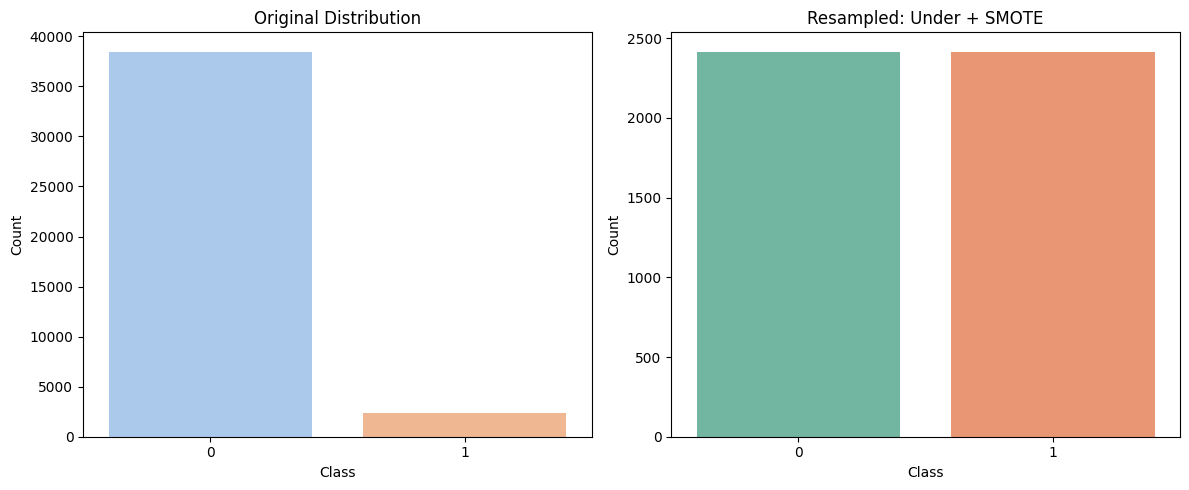


🔁 RandomUnderSampler + ADASYN


<ipython-input-28-c274e155a28c>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-28-c274e155a28c>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


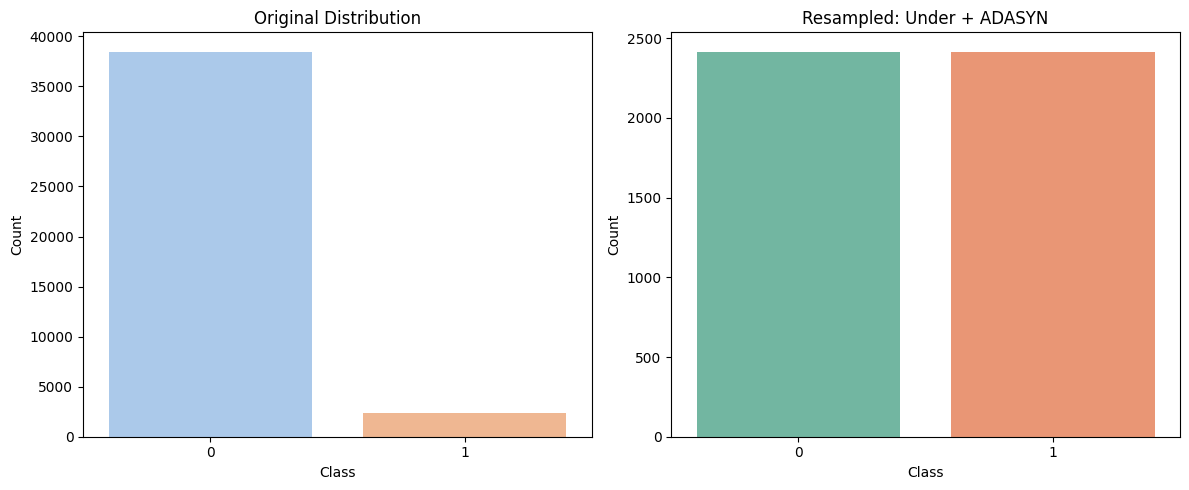

In [38]:
sampled_data_dict = visualize_combined_sampling_techniques(X_train_vect, y_train)

In [39]:
X_under_ros, y_under_ros = sampled_data_dict['Under + ROS']
X_under_smote, y_under_smote = sampled_data_dict['Under + SMOTE']
X_under_adasyn, y_under_adasyn = sampled_data_dict['Under + ADASYN']


RUS + ROS 

KNeighborsClassifier
****Results****
AUC: 55.9203%
Classification report: 
                    pre       rec       spe        f1       geo       iba       sup

          0       0.96      0.49      0.63      0.65      0.55      0.30      9635
          1       0.07      0.63      0.49      0.13      0.55      0.31       588

avg / total       0.90      0.50      0.62      0.62      0.55      0.30     10223



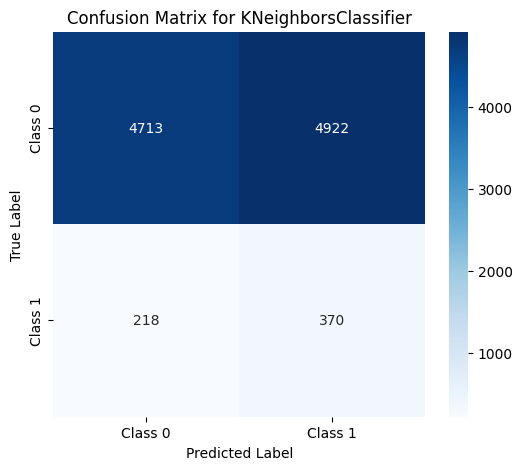

DecisionTreeClassifier
****Results****
AUC: 54.0489%
Classification report: 
                    pre       rec       spe        f1       geo       iba       sup

          0       0.95      0.55      0.53      0.69      0.54      0.29      9635
          1       0.07      0.53      0.55      0.12      0.54      0.29       588

avg / total       0.90      0.55      0.53      0.66      0.54      0.29     10223



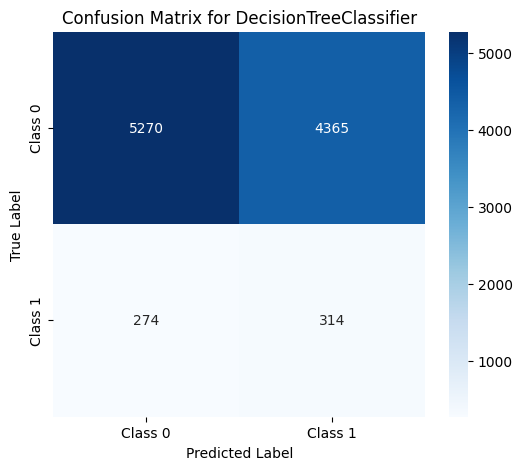

RandomForestClassifier
****Results****
AUC: 63.0560%
Classification report: 
                    pre       rec       spe        f1       geo       iba       sup

          0       0.96      0.66      0.60      0.79      0.63      0.40      9635
          1       0.10      0.60      0.66      0.17      0.63      0.39       588

avg / total       0.91      0.66      0.60      0.75      0.63      0.40     10223



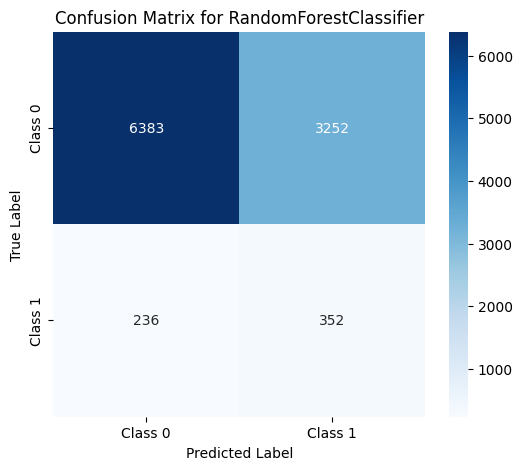

AdaBoostClassifier
****Results****
AUC: 60.7511%
Classification report: 
                    pre       rec       spe        f1       geo       iba       sup

          0       0.96      0.62      0.59      0.76      0.61      0.37      9635
          1       0.09      0.59      0.62      0.15      0.61      0.37       588

avg / total       0.91      0.62      0.60      0.72      0.61      0.37     10223



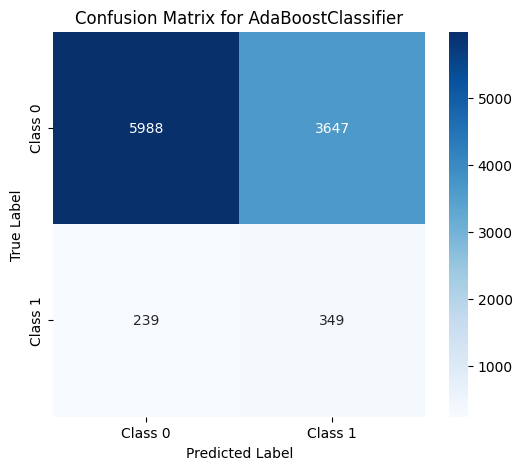

GradientBoostingClassifier
****Results****
AUC: 62.4466%
Classification report: 
                    pre       rec       spe        f1       geo       iba       sup

          0       0.96      0.62      0.63      0.76      0.62      0.39      9635
          1       0.09      0.63      0.62      0.16      0.62      0.39       588

avg / total       0.91      0.62      0.63      0.72      0.62      0.39     10223



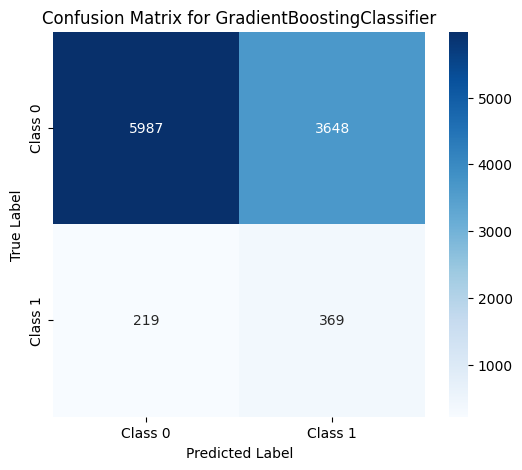

LogisticRegression
****Results****
AUC: 56.5931%
Classification report: 
                    pre       rec       spe        f1       geo       iba       sup

          0       0.96      0.56      0.57      0.70      0.57      0.32      9635
          1       0.07      0.57      0.56      0.13      0.57      0.32       588

avg / total       0.90      0.56      0.57      0.67      0.57      0.32     10223



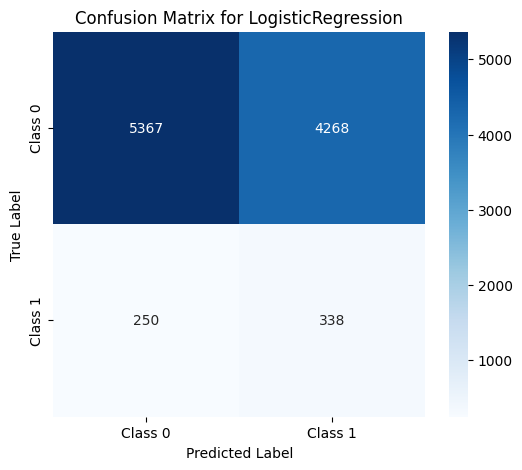

RUS + SMOTE 

KNeighborsClassifier
****Results****
AUC: 55.9746%
Classification report: 
                    pre       rec       spe        f1       geo       iba       sup

          0       0.96      0.50      0.62      0.65      0.56      0.31      9635
          1       0.07      0.62      0.50      0.13      0.56      0.31       588

avg / total       0.90      0.50      0.62      0.62      0.56      0.31     10223



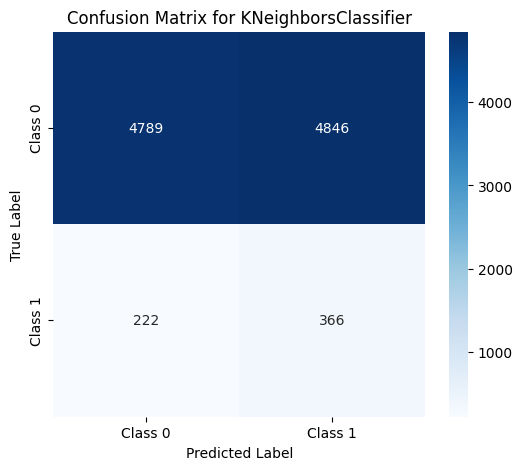

DecisionTreeClassifier
****Results****
AUC: 56.2513%
Classification report: 
                    pre       rec       spe        f1       geo       iba       sup

          0       0.95      0.57      0.56      0.71      0.56      0.32      9635
          1       0.07      0.56      0.57      0.13      0.56      0.32       588

avg / total       0.90      0.57      0.56      0.68      0.56      0.32     10223



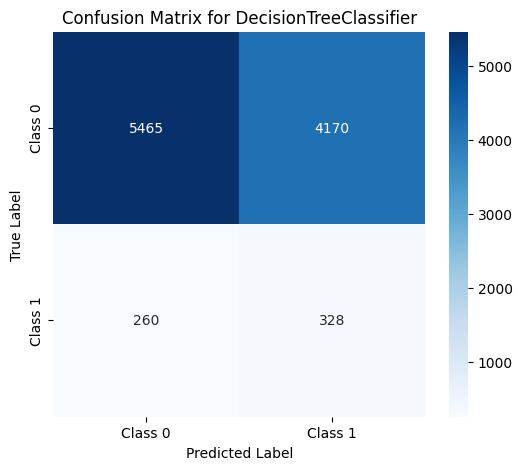

RandomForestClassifier
****Results****
AUC: 64.1025%
Classification report: 
                    pre       rec       spe        f1       geo       iba       sup

          0       0.97      0.64      0.64      0.77      0.64      0.41      9635
          1       0.10      0.64      0.64      0.17      0.64      0.41       588

avg / total       0.92      0.64      0.64      0.74      0.64      0.41     10223



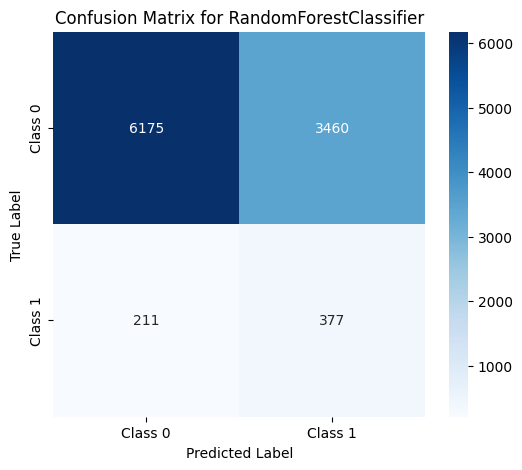

AdaBoostClassifier
****Results****
AUC: 63.9114%
Classification report: 
                    pre       rec       spe        f1       geo       iba       sup

          0       0.97      0.61      0.67      0.75      0.64      0.41      9635
          1       0.09      0.67      0.61      0.17      0.64      0.41       588

avg / total       0.92      0.61      0.67      0.71      0.64      0.41     10223



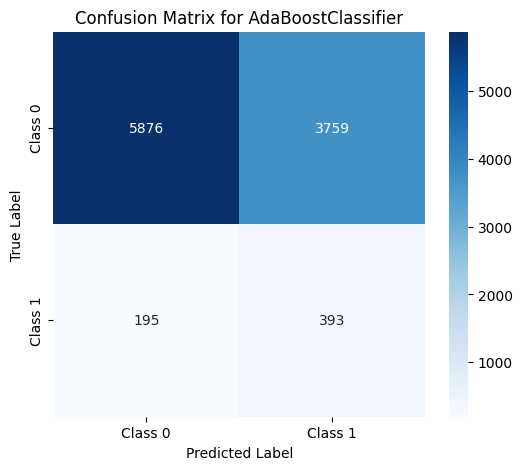

GradientBoostingClassifier
****Results****
AUC: 64.2902%
Classification report: 
                    pre       rec       spe        f1       geo       iba       sup

          0       0.97      0.62      0.67      0.75      0.64      0.41      9635
          1       0.10      0.67      0.62      0.17      0.64      0.41       588

avg / total       0.92      0.62      0.67      0.72      0.64      0.41     10223



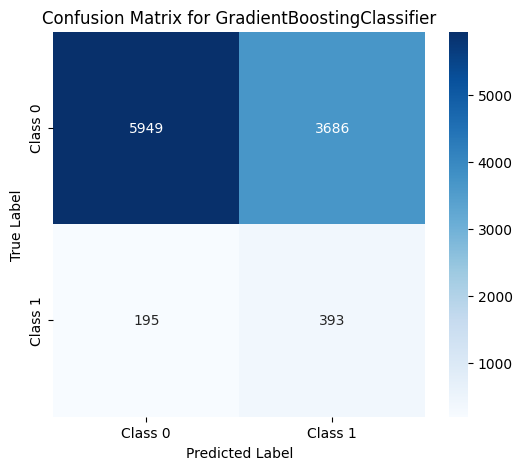

LogisticRegression
****Results****
AUC: 56.6401%
Classification report: 
                    pre       rec       spe        f1       geo       iba       sup

          0       0.96      0.57      0.57      0.71      0.57      0.32      9635
          1       0.07      0.57      0.57      0.13      0.57      0.32       588

avg / total       0.90      0.57      0.57      0.68      0.57      0.32     10223



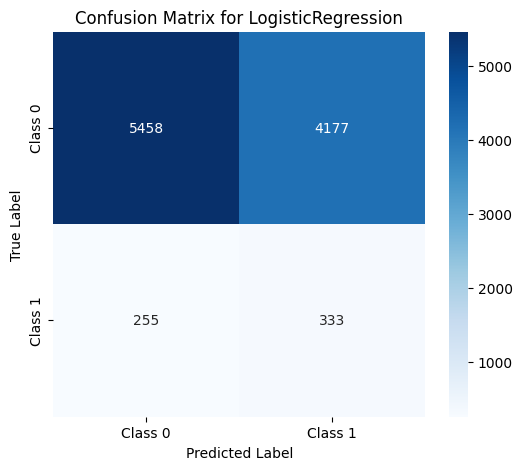

RUS + ADASYN 

KNeighborsClassifier
****Results****
AUC: 54.0619%
Classification report: 
                    pre       rec       spe        f1       geo       iba       sup

          0       0.95      0.49      0.59      0.64      0.54      0.29      9635
          1       0.07      0.59      0.49      0.12      0.54      0.29       588

avg / total       0.90      0.49      0.59      0.61      0.54      0.29     10223



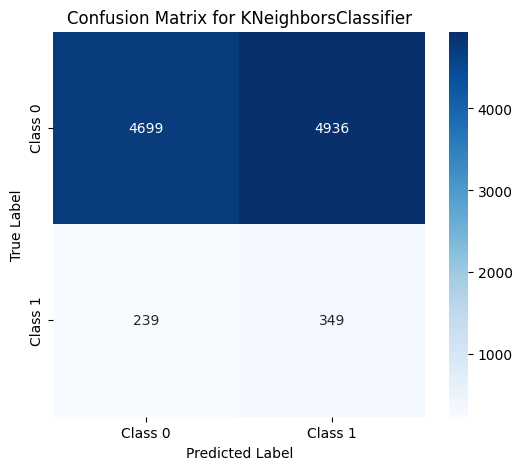

DecisionTreeClassifier
****Results****
AUC: 57.5201%
Classification report: 
                    pre       rec       spe        f1       geo       iba       sup

          0       0.96      0.56      0.60      0.70      0.57      0.33      9635
          1       0.08      0.60      0.56      0.13      0.57      0.33       588

avg / total       0.91      0.56      0.59      0.67      0.57      0.33     10223



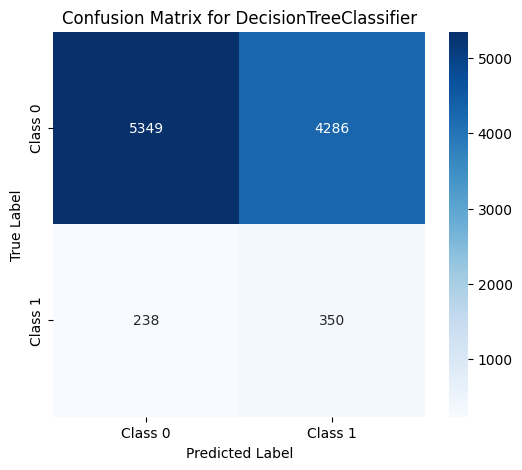

RandomForestClassifier
****Results****
AUC: 63.3990%
Classification report: 
                    pre       rec       spe        f1       geo       iba       sup

          0       0.97      0.66      0.61      0.78      0.63      0.40      9635
          1       0.10      0.61      0.66      0.17      0.63      0.40       588

avg / total       0.92      0.65      0.61      0.75      0.63      0.40     10223



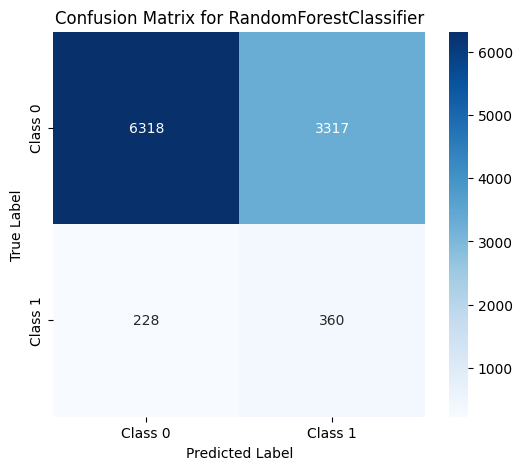

AdaBoostClassifier
****Results****
AUC: 61.9328%
Classification report: 
                    pre       rec       spe        f1       geo       iba       sup

          0       0.96      0.61      0.63      0.75      0.62      0.38      9635
          1       0.09      0.63      0.61      0.16      0.62      0.38       588

avg / total       0.91      0.61      0.63      0.71      0.62      0.38     10223



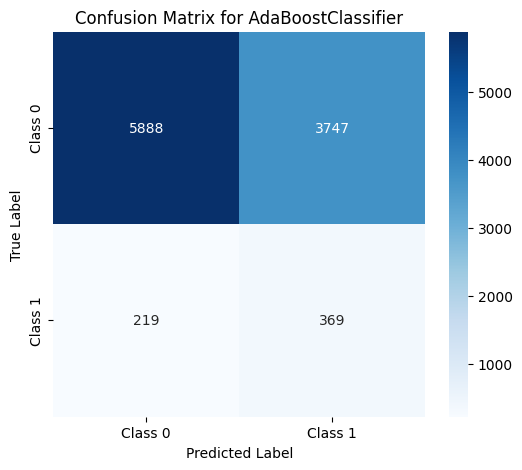

GradientBoostingClassifier
****Results****
AUC: 62.6762%
Classification report: 
                    pre       rec       spe        f1       geo       iba       sup

          0       0.97      0.61      0.65      0.75      0.63      0.39      9635
          1       0.09      0.65      0.61      0.16      0.63      0.39       588

avg / total       0.92      0.61      0.64      0.71      0.63      0.39     10223



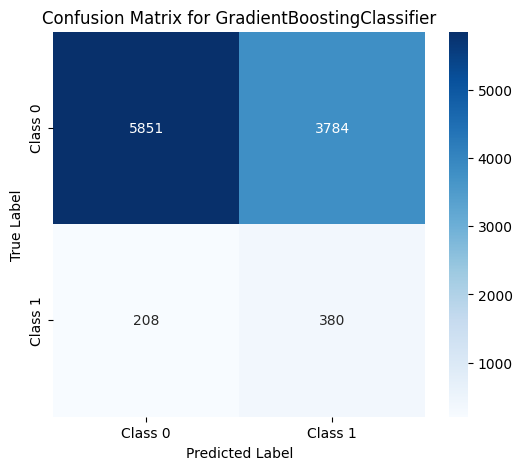

LogisticRegression
****Results****
AUC: 56.8266%
Classification report: 
                    pre       rec       spe        f1       geo       iba       sup

          0       0.96      0.56      0.57      0.71      0.57      0.32      9635
          1       0.07      0.57      0.56      0.13      0.57      0.32       588

avg / total       0.91      0.56      0.57      0.67      0.57      0.32     10223



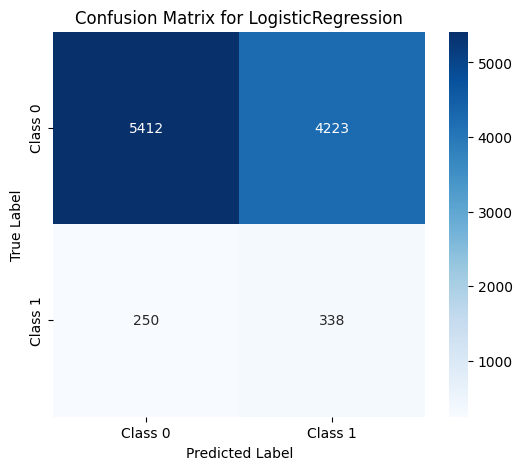

In [40]:
combine_sampling_results(X_under_ros, y_under_ros, X_under_smote, y_under_smote, X_under_adasyn, y_under_adasyn, X_test_vect, y_test)